In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from resources.conv_learner import *
import os
from pathlib import Path
from os.path import basename
import skimage.external.tifffile as tiff
import pickle


In [3]:
test_dir = "datasets/yeast_v4/"
data_path = Path(test_dir)

In [4]:
# calculate
test_dirs , train_dirs = [], []

for ds_dir in data_path.iterdir():
    if 'DS_Store' not in str(ds_dir):
        for class_dir in ds_dir.iterdir():
            if 'DS_Store' not in str(class_dir):
                if 'test' in str(class_dir): test_dirs.append(class_dir)
                elif 'train' in str(class_dir): train_dirs.append(class_dir)

In [5]:
import numpy as np
stats = {}

class_dirs = zip(test_dirs,train_dirs)
for test, train in class_dirs:
    class_images = []
    class_name = basename(str(test).split('/')[-1]) #adding "basename" function avoids saving entire path; kinda nicer
    class_images = []
    for dir_ in [test,train]:
        # read from each dir and append to the images
        for file in dir_.iterdir():
            image = tiff.imread(str(file))
            if image.shape[-1] == 200 and image.shape[-2] ==200:
                class_images.append(image)
            else:
                os.remove(str(file)) # get rid of the non square images
                print(f"removed file: {str(file)}")
    
    # calc std
    print(class_name)
    mean, stdev = np.mean(class_images, axis=(0,2,3))/65535 , np.std(class_images, axis=(0,2,3))/65535
    stats[class_name] = (mean, stdev)

mfb1KO
mfb1KO_mmr1KO
mmr1KO
WT


In [6]:
# pickle the stats dict

with open('./norm_stats.dict','wb') as file:
    pickle.dump(stats,file)

In [7]:
classes = ('WT', 'mfb1KO', 'mfb1KO_mmr1KO', 'mmr1KO')
PATH = "datasets/yeast_v4/"

In [8]:
def get_data(sz,bs):
    create, lbl2index = ImageClassifierData.prepare_from_path(PATH, val_name='test', bs=bs)
    stats_dict = {lbl2index[key]: val for key, val in stats.items()}
    tfms = tfms_from_stats(stats_dict, sz, aug_tfms=[RandomDihedral()], pad=sz//8) #even without transformations and padding -> failure
    print(lbl2index)
    return create(tfms)

### the eventual sub-function of ImageClassifierData (read_dirs) expects subdirectories for each class: 
### e.g. all "test/cat.png" images should be in a "cat" folder. 

In [9]:
bs=64

In [10]:
data = get_data(200,bs)

inited with dict: {1: (array([0.00794, 0.00476]), array([0.00073, 0.00156])), 2: (array([0.0079 , 0.00474]), array([0.00073, 0.00153])), 3: (array([0.00797, 0.00482]), array([0.00075, 0.00169])), 0: (array([0.00796, 0.00474]), array([0.00074, 0.00146]))}
{'WT': 0, 'mfb1KO': 1, 'mfb1KO_mmr1KO': 2, 'mmr1KO': 3}


In [11]:
x,y=next(iter(data.trn_dl))

In [12]:
print(y)


 1
 0
 0
 0
 0
 0
 1
 1
 3
 0
 1
 1
 0
 3
 2
 1
 0
 1
 3
 0
 0
 0
 2
 3
 1
 3
 3
 3
 1
 2
 3
 3
 1
 1
 1
 3
 3
 3
 2
 3
 0
 2
 1
 0
 3
 2
 0
 3
 3
 0
 1
 1
 1
 2
 2
 1
 2
 2
 3
 3
 1
 2
 0
 2
[torch.LongTensor of size 64]



In [14]:
torch.__version__

'0.3.1.post2'

C:\Anaconda3\envs\fastai\lib\site-packages\matplotlib\axes\_base.py:3124: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0
  'left=%s, right=%s') % (left, right))


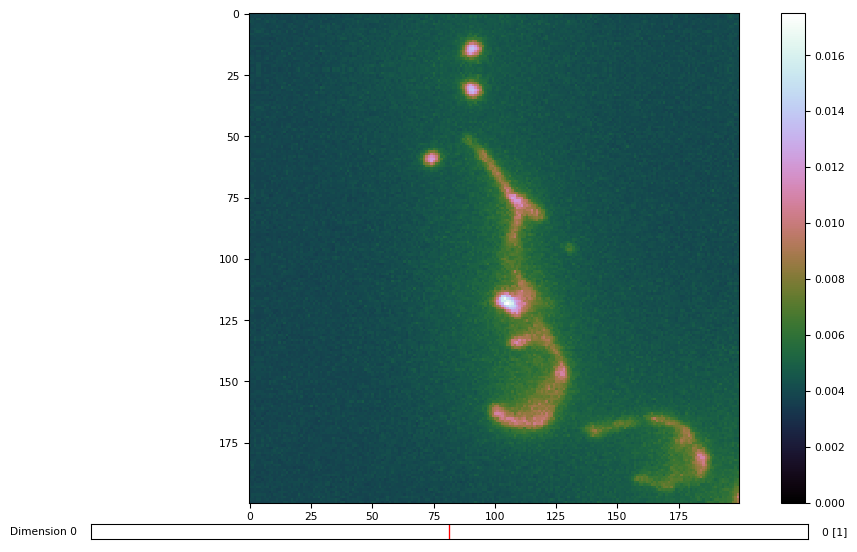

In [13]:
idx = 0
tiff.imshow(data.trn_ds.denorm(x[idx], y[idx]).squeeze()[:,:,1]); #denorm function called has a rollaxis() hence indexing changes.

# Training setup

In [ ]:
class SimpleNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        for l in self.layers:
            l_x = l(x)
            x = F.relu(l_x)
        return F.log_softmax(l_x, dim=-1)

In [ ]:
learn = ConvLearner.from_model_data(SimpleNet([200*200*2, 40, 2]), data) #(!) change channel-number & classes accordingly

In [ ]:
learn, [o.numel() for o in learn.model.parameters()]

In [ ]:
learn.summary()

In [ ]:
lr=1e-5

In [ ]:
%time learn.fit(lr, 200, cycle_len=1)

## ConvNet

In [32]:
class ConvNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(layers[i], layers[i + 1], kernel_size=5, stride=1, padding=(2,2))
            for i in range(len(layers) - 1)])
        self.pool = nn.AdaptiveMaxPool2d(1)
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = F.relu(l(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [33]:
learn = ConvLearner.from_model_data(ConvNet([2, 20, 40, 80], 4), data)

In [34]:
learn.summary() ### learner.summary is hardcording the number of channels = 3

RuntimeError: Given groups=1, weight[20, 4, 5, 5], so expected input[2, 2, 200, 200] to have 4 channels, but got 2 channels instead

In [23]:
lr=1e-10

In [24]:
%time learn.fit(lr, 10, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                                                                                                                                                                            
    0      1.322663   1.423939   0.228571  
    1      1.326295   1.423939   0.228571                                                                                                                                                                            
    2      1.324928   1.423939   0.228571                                                                                                                                                                            
 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 6/10 [00:05<00:03,  1.03it/s, loss=1.33]

KeyboardInterrupt: 

In [ ]:
torch.cuda.is_available()

## ResNet_with_Batchnorm

In [12]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1))
        self.m = nn.Parameter(torch.ones(nf,1,1))
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
        if self.training:
            self.means = x_chan.mean(1)[:,None,None]
            self.stds  = x_chan.std (1)[:,None,None]
        return (x-self.means) / self.stds *self.m + self.a

In [13]:
class ResnetLayer(BnLayer):
    def forward(self, x): return x + super().forward(x)

In [14]:
class Resnet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [15]:
learn = ConvLearner.from_model_data(Resnet([10, 20, 40, 80, 160], 4), data)

In [16]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 2, 200, 200]),
                           ('output_shape', [-1, 10, 200, 200]),
                           ('trainable', True),
                           ('nb_params', 510)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 10, 200, 200]),
                           ('output_shape', [-1, 20, 100, 100]),
                           ('trainable', True),
                           ('nb_params', 1800)])),
             ('BnLayer-3',
              OrderedDict([('input_shape', [-1, 10, 200, 200]),
                           ('output_shape', [-1, 20, 100, 100]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 20, 100, 100]),
                           ('output_shape', [-1, 20, 100, 100]),
                           ('trainable', True),
                           ('nb_params', 3600)])),
             ('ResnetLayer-5',
     

In [18]:
wd=1e-5

In [19]:
%time learn.fit(1e-2, 8, cycle_len=4, wds=wd)

epoch      trn_loss   val_loss   accuracy                                                                                                                                                                            
    0      48.563653  65.042301  0.228571  
 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 6/10 [00:03<00:02,  1.95it/s, loss=40.7]


KeyboardInterrupt: 

In [49]:
%time learn.fit(1e-2, 8, wds=wd, cycle_len=4, use_clr=(20,8, 0.95, 0.85))

epoch      trn_loss   val_loss   accuracy                                                                                                                                                                            
    0      1.001357   1.401626   0.47619   
    1      1.01478    1.333267   0.428571                                                                                                                                                                            
    2      1.049442   1.210411   0.447619                                                                                                                                                                            
    3      1.037015   1.283607   0.47619                                                                                                                                                                             
    4      1.029389   1.289065   0.495238                                                           

[array([1.08625]), 0.5238095246610187]

In [20]:
%time learn.fit(1e-2, 8, wds=wd, cycle_len=40, use_clr=(20,8, 0.95, 0.85))

epoch      trn_loss   val_loss   accuracy                                                                                                                                                                            
    0      15.853056  12.190327  0.32381   
    1      11.521627  3.462061   0.238095                                                                                                                                                                            
    2      7.672445   1.542595   0.27619                                                                                                                                                                             
    3      5.674883   1.355551   0.4                                                                                                                                                                                 
    4      4.44524    1.45432    0.295238                                                           

    76     0.733638   1.114137   0.561905                                                                                                                                                                            
    77     0.728903   1.006554   0.590476                                                                                                                                                                            
    78     0.728091   1.009754   0.590476                                                                                                                                                                            
    79     0.718118   1.001939   0.561905                                                                                                                                                                            
    80     0.710953   1.09576    0.542857                                                                                                       

   152     0.524013   0.941924   0.628571                                                                                                                                                                            
   153     0.511051   0.944797   0.609524                                                                                                                                                                            
   154     0.508315   1.258017   0.609524                                                                                                                                                                            
   155     0.500762   0.964263   0.657143                                                                                                                                                                            
   156     0.501229   1.103468   0.580952                                                                                                       

   228     0.408102   1.06222    0.628571                                                                                                                                                                            
   229     0.399172   0.987417   0.609524                                                                                                                                                                            
   230     0.391128   0.914872   0.638095                                                                                                                                                                            
   231     0.388556   0.975346   0.628571                                                                                                                                                                            
   232     0.382658   0.938573   0.666667                                                                                                       

KeyboardInterrupt: 

In [21]:
%time learn.fit(1e-3, 8, wds=wd, cycle_len=40, use_clr=(20,8, 0.95, 0.85))

epoch      trn_loss   val_loss   accuracy                                                                                                                                                                            
    0      0.41657    1.03402    0.619048  
    1      0.397302   0.906338   0.647619                                                                                                                                                                            
    2      0.381994   0.849025   0.647619                                                                                                                                                                            
    3      0.366051   0.887515   0.67619                                                                                                                                                                             
    4      0.348402   0.940935   0.657143                                                           

KeyboardInterrupt: 

In [ ]:
learn.save('tmp_resnet_clr')